# "Creating an implementation of Learner"

>**Disclaimer:** this post should be seen as a supplement to chapter 4 of *Deep Learning for Coders with fastai & PyTorch*, by Jeremy Howard and Sylvain Gugger. A lot of code is lifted from there and I will mostly throw mental notes around. As such, it is highly recommended that you are familiar with the material before you read it. If you want to know more about the book or its companion course, you can visit this link: https://course.fast.ai/

Having recently started reading the fantastic *Deep Learning for Coders with fastai & PyTorch*, I was pretty impressed by the fourth chapter (*Under the hood: Training a Digit Classifier*) where we get to see the foundations of Deep Learning.

I had to do a lot of back and forth to experiment and make sure I understood everything, but I think I got a good grasp of the concepts explored here, such as Stochastic Gradient Descent (or SGD).

At the end of the chapter, you are invited to implement your own [Learner](https://docs.fast.ai/learner.html#Learner). This is a class whose purpose is to handle the training loop with your data, model and loss function.

## An interesting experiment

What I expected to be a simple exercise turned out to be a good review of this chapter's content. Because of this, I decided to discuss the implementation I came up with.

I relied on my intuition of how Learner would handle the training loop, *as it was explained in this chapter*, and mostly focused on making it work with the code that was exposed so far.

So it might be very different than how it's actually done, but this is the perfect excuse to go over the bits I found interesting.

> **Another disclaimer**: expect a lot of the code to be pretty much a repeat of the book's content. Our focus today is the Learner, but I also wanted to keep a collection of personal notes for my own learning needs. Hopefully it is useful to you as well.

# "Creating an implementation of Learner"
> "A little rundown on an assignment from Deep Learning for Coders with fastai & PyTorch"

- toc: true
- branch: master
- badges: false
- comments: true
- author: CGfrac
- categories: [fastai]

## Let's first get our data ready

I decided to reuse the MNIST sample from this chapter, so I could directly compare my work with the book and focus on my Learner itself.

As a reminder, the MNIST sample contains digits 3 and 7, so our goal here is pretty simple: given 3 and 7 pictures, we must classify them correctly. We will quickly go over the points of interest, or rather my own mental notes to make sense of the datasets, as it is essentially a stripped down version of the work done in this chapter.

First we need to download the MNIST sample:

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

Now we want paths to the respective training folders for 3 and 7. We will also use fastai's `ls` method on threes to get an idea of what the folder is like. Notice the number of items at the beginning of the ouput.

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

We need to convert these images into something our computers can work with. That is, arrays where each cell corresponds to a pixel, expressed as a numerical value.

More precisely and for our needs, PyTorch's tensors are adequate. It will make it very convenient to make our calculations later, thanks to **broadcasting** in particular. Moreover, you might also remember that it is great for performance.

In [6]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

So far so good. As you can see, the length of `three_tensors` corresponds to the number of items we had in `three`.

Now let's use `torch.stack` to turn each list into a single *rank-3 tensor*. And let's convert our values to floats between 0 and 1 while we are at it.

Remember that our values range from 0 (black) to 255 (white), so simply dividing by 255 will do the trick. Notice how we directly divide the tensor. That's one of the magical things about broadcasting.

In [7]:
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes.shape

torch.Size([6131, 28, 28])

The shape confirms that our `stacked_threes` is a neat rank-3 tensor.

So that's our independent variables (or *xs*) nearly ready. Let's concatenate them into a single tensor, that we will convert the result to rank-2, where our pixels (28x28) are expressed into a single dimension.

The former is achieved with `torch.cat`, the latter with `view`.

In [8]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

We also made sure we had labels for our pictures with `train_y`. As you can see, our 3s will have a label of 1, and our 7s get 0. This will be handy for our `mnist_loss` method later.

The shapes are self-explanatory, but so we are 100% clear: 12396 is how many pictures we have in total (6131 + 6265), 784 is our 28x28 pixels per picture and 1 is our labels (that are single digits).

Next is having our `train_x` and `train_y` into a 2D list. We can easily achieve that with `zip`.

In [9]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y, len(dset)

(torch.Size([784]), tensor([1]), 12396)

Perfect! Now each picture is next to its appropriate label in a list of length 12396.

All that's left now is to feed our dataset to a `DataLoader`. This way we can iterate over the dataset by batches, which we will set to size 256.

In [10]:
train_dl = DataLoader(dset, batch_size=256)
xb, yb = first(train_dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

At this point you might remember that our training dataset will not help much if we do not have a validation one as well. We need to calculate our accuracy and see how well we are doing after all.

Let's repeat the previous steps for our validation dataset as well, then.

In [11]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float() / 255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

You can see how we have generated our rank-3 tensors with less lines of codes.

Withour further ado, let's get our `DataLoader` ready.

In [12]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=255)

We are all set. Let's finally bundle our `train_dl` and `valid_dl` into a `DataLoaders`.

This is what we will feed our Learner with at initialization.

In [13]:
dls = DataLoaders(train_dl, valid_dl)

## A little reminder of the gradient descent process

Before we proceed, it will be helpful to remind ourselves of what the *gradient descent process* looks like. We do this now because the following steps won't come in order (at least until the training loop of our Learner itself is finally discussed).

If anything, writing this notebook made me realize how great Jeremy Howard and Sylvain Gugger were, at exposing the pieces in a way we could understand easily.

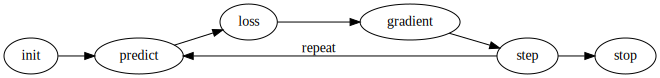

In [14]:
#id gradient descent process
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

Make sure that you understand the process before moving forward. Revisit the course and book content if necessary!

## Implementing our loss and accuracy functions

Before we implement our classes proper, we could get our loss and batch accuracy functions ready. They are going to be useful way later in our code, but they are short and help use make sense of some of the decisions we took when preparing our `DataLoaders`.

> **Tip:** from this point onward, do not hesitate to do a bit of back and forth with later explanations. I will do my best to give pointers in case you are confused. 

### The loss function

First, let's go over our loss function:

In [15]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1-predictions, predictions).mean()

The *loss function* is a critical piece of our training loop. This is where it sits in our *gradient descent* process:

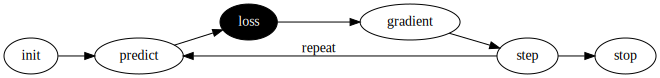

In [16]:
#id loss function
#caption The loss function in our gradient descent process
#alt Graph showing the steps for Gradient Descent with loss highlighted
gv('''
init->predict->loss
loss[style=filled,fillcolor=black,fontcolor=white]
loss->gradient->step->stop
step->predict[label=repeat]
''')

If you need to track down where it is called in our Learner class, check the `calc_grad` method. This is where the loss will be calculated after we got our predictions through our model.

Remember how our 3s were labeled as 1 and our 7s as 0 in `train_y`? This is where it comes in handy: if the target (our y) is a 3, then we will subtract the prediction from 1 to see how close we were to that number. Likewise, if our target is a 7, then our prediction alone will tell how close we were to 0.

Of note as well, is our use of the sigmoid function: to make the above calculation work as expected, we need to ensure our predictions are between 1 and 0.

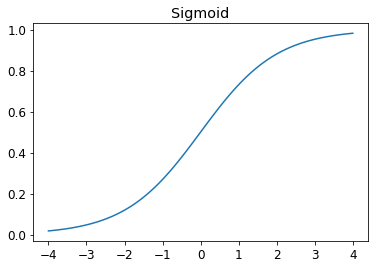

In [36]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

You can also pay attention to the smooth curve we get here. That will make our gradients more useful, as you may remember.

### The metrics function

While the loss function is useful to our training loop, we also need something that allows us to see how well our model is doing. This is where our metrics come in.

Since we are working on a classification problem, accuracy seems to be the metric of choice.

In [18]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

Note that as the name implies, we are going to calculate our accuracy over batches as we set them in our `train_dl` and `valid_dl`. Speaking of the latter, this is where our very important validation set comes into play.

As for the calculations themselves, we are again using `torch.sigmoid` for the same reasons as the loss function. While the actual accuracy will simply be the mean of our correct predictions (expressed as booleans).

Our Learner will rely on it in `validate_epoch`.

## The Optimizer class 

In [19]:
class MySGD:
    def __init__(self, params):
        self.params = list(params)
    
    def set_learning_rate(self, lr):
        self.lr = lr
    
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
            
    def zero_grad(self):
        for p in self.params:
            p.grad = None

You might recognize the `BasicOptim` class from the part *Creating an Optimizer* in the chapter... Indeed this is simply the same class but going with my naming convention for today, and a minor `set_learning_rate` helper method, so that we feed our learning rate to the class only once.

So, we are now talking about this part in the gradient descent process:

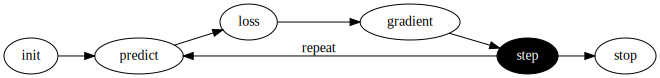

In [20]:
#id step function
#caption The step function in our gradient descent process
#alt Graph showing the steps for Gradient Descent with step highlighted
gv('''
init->predict->loss->gradient->step
step[style=filled,fillcolor=black,fontcolor=white]
step->stop
step->predict[label=repeat]
''')

So what is our `step` method doing exactly?

Remember what is the goal of our Stochastic Gradient Descent function: updating our parameters so that they lead to a lower loss. For this we are using our gradient to shortcut our way toward a smaller loss. The learning rate helps us modulate how big such a step will be.

Just as important for us here, is the `zero_grad` method. We need it or PyTorch will make our gradient calculations cumulatives. We do not want that! For each epoch, we want the gradients for our current loss so as to adjust as necessary.

## A basic neural network model

In [21]:
class MySimpleNet:
    def __init__(self, size):
        self.w1 = self.init_params((size, 30))
        self.b1 = self.init_params(30)
        self.w2 = self.init_params((30,1))
        self.b2 = self.init_params(1)
    
    def init_params(self, size, std=1.0):
        return (torch.randn(size)*std).requires_grad_()

    def parameters(self):
        return self.w1, self.b1, self.w2, self.b1
    
    def __call__(self, xb):
        res = xb@self.w1 + self.b1
        res = res.max(tensor(0.0))
        res = res@self.w2 + self.b2
        return res

I hardcoded the dimensions to `size, 30` (where size would be 28x28 for our purposes today). I'm not sure if it is good practice, but probably fine for such a rudimentary model. I will keep that in mind when going deeper (no pun intended) into Deep Learning.

### Our parameters

`init_params` is of particular importance. This is actually our first step in the Gradient Descent process! Indeed, our weights and biases are the parameters that will be used in basically every step of the training loop.

For that effect, they will be randomly generated, and we will make sure that PyTorch keeps track of their gradients using `requires_grad`.

Accordingly, this is where we are in the process:

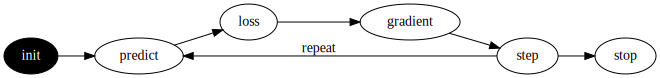

In [22]:
#id init
#caption Initializing in our gradient descent process
#alt Graph showing the steps for Gradient Descent with initialization highlighted
gv('''
init[style=filled,fillcolor=black,fontcolor=white]
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

The `parameters` method will return all of our weights and biases together, for convenience.

### Neural network

Lastly, and this is the fun part, we have a callable method that justifies the name for our class: this is our simple neural net, as it was explained to us by Jeremy Howard and Sylvain Gugger!

I was pretty surprised by how straightforward it is: two matrix multiplications in the form of the equation `batch @ weights + bias`, separated by a nonlinear function in the middle (this is the *rectified linear unit* or ReLU, whose calculation I decided to not abstract with the library, so that you can remind yourself how simple it actually is). This is our layers!

Two things to keep in mind here:

1. It is necessary for us to have a nonlinear function to decouple both linear functions, least we would not benefit from having multiple layers.
2. Pay attention to the dimensions of our matrices as the calculations go. With our pictures that means we do:
    * [256x784] x [784x30] + [30] = [256x30] matrix
    * Our ReLU function to turn all negative values to 0 in the resulting matrix
    * [256x30] x [30x1] + [1] = [256x1] vector
    
   Where 256 is the size of our batch and 784 is our 28x28 pixels.
   
If you are not sure of what the last part means, I recommend you to review matrix multiplications (there is a wonderful explanation on page 165). *Broadcasting* is also at play here.

Anyway, this magical piece of code is taking care of this part of our process:

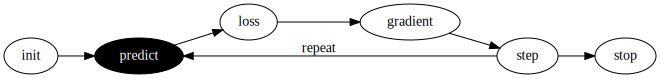

In [23]:
#id prediction
#caption Where predictions stand in our gradient descent process
#alt Graph showing the steps for Gradient Descent with predict highlighted
gv('''
init->predict
predict[style=filled,fillcolor=black,fontcolor=white]
predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

I'm not entirely sure on why we bundle the parameters together with the model, but my intuition is that by doing so we ensure that our matrices are properly sized for the necessary matrix multiplications.

## The Learner class

Finally, the reason we have been writing this piece!

In [24]:
class MyLearner:
    def __init__(self, dls, model, opt_func, loss_func, metrics):
        self.train_dl, self.valid_dl = dls
        self.model = model
        self.opt_func = opt_func(model.parameters())
        self.loss_func = loss_func
        self.metrics = metrics
        self.recorder = {}
        
    def calc_grad(self, xb, yb):
        preds = self.model(xb)
        loss = self.loss_func(preds, yb)
        loss.backward()
        
    def train_epoch(self):
        for xb, yb in self.train_dl:
            self.calc_grad(xb, yb)
            self.opt_func.step()
            self.opt_func.zero_grad()
        
    def validate_epoch(self):
        accs = [self.metrics(self.model(xb), yb) for xb,yb in self.valid_dl]
        return round(torch.stack(accs).mean().item(), 4)
    
    def fit(self, epochs, lr):
        self.opt_func.set_learning_rate(lr)
        for i in range(epochs):
            self.train_epoch()
            mean_accuracy = self.validate_epoch()
            self.recorder[i] = mean_accuracy
            print(mean_accuracy, end=' ')

As you can see, there is a lot going on. However, at the same time, it is still very close to the logic exposed by this chapter. 

Let's take a look in order of execution.

### init

I just went with what the instantiation looked like, which meant providing the `DataLoaders`, then giving a model (this is our simple neural network), the optimization function (our SGD), the loss function (`mnist_loss` earlier) and finally our metrics (`batch_accuracy`).

Our `DataLoaders` is separated back to our training and validation `DataLoader`. It was convenient for my immediate needs but maybe there is a saner way to go about it, in a more complex implementation of `Learner`.

I made a bare bone `recorder` in the form of a dictionary as well. It's clearly not what the recorder actually is in fastai, but all I wanted was a quick and dirty way to plot our metrics later.

With that explanation being out of the way, let's just initialize our Learner object now:

In [31]:
learn = MyLearner(dls, model=MySimpleNet(28*28), opt_func=MySGD, loss_func=mnist_loss, metrics=batch_accuracy)

Note that we initialize our model there. Thus fulfilling the first step of this graph:

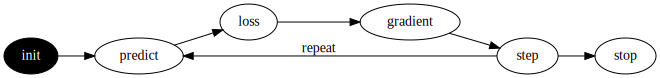

In [41]:
#id init2
#caption Initializing in our gradient descent process
#alt Graph showing the steps for Gradient Descent with initialization highlighted
gv('''
init[style=filled,fillcolor=black,fontcolor=white]
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

### The training loop

Now we can focus on the training loop itself, whose handling is the purpose of our Learner class.

#### fit

It all begins with our `fit` method, where we give the number of epochs we will go through. This is also where the *learning rate* is set for the optimization function (again, the SGD we initialize the Learner with).

At the beginning of each iteration, we use `train_epoch` which we will cover now.

#### train_epoch

From there, we are going to loop through all the batches of our `train_dl`, separated into our xs (remember: our pictures) and ys (the labels)

First in our loop, `calc_grad` is called.

#### calc_grad

You may have realized, but we are finally mentioning a critical piece of the Gradient Descent process. That is:

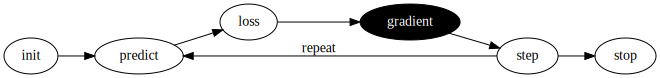

In [26]:
#id gradient
#caption Where the gradient step stands in our gradient descent process
#alt Graph showing the steps for Gradient Descent with gradient highlighted
gv('''
init->predict->loss->gradient
gradient[style=filled,fillcolor=black,fontcolor=white]
gradient->step->stop
step->predict[label=repeat]
''')

But in reality, since the method is first calculating the predictions using our neural network, and the loss using `mnist_loss` with said predictions and this batch's ys, this method is essentially taking care of much more:

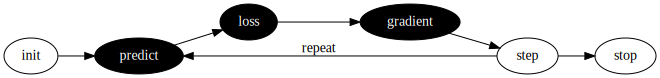

In [37]:
#id calc_grad
#caption Everything calc_grad takes care of in our gradient descent process
#alt Graph showing the steps for Gradient Descent with predict, loss and gradient highlighted
gv('''
init->predict
predict[style=filled,fillcolor=black,fontcolor=white]
predict->loss
loss[style=filled,fillcolor=black,fontcolor=white]
loss->gradient
gradient[style=filled,fillcolor=black,fontcolor=white]
gradient->step->stop
step->predict[label=repeat]
''')

The gradient itself is calculated using `backward`. Remember when we used `requires_grad` during parameters initialization? This was in preparation for this moment: the *backward propagation*!

Since PyTorch kept in mind our parameters, from our loss it will be able to work its way back to the predictions, then the parameters, to distribute the gradients.

From there we are done with the current batch and can go back to `train_epoch`.

#### back to train_epoch

Now that we have calculated the gradients, we need to update the parameters using our optimization function.

This is done using `step` in our SGD class, thus:

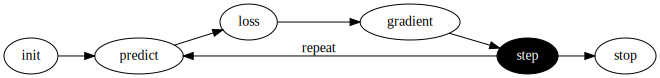

In [39]:
#id step function again
#caption The step function in our gradient descent process
#alt Graph showing the steps for Gradient Descent with step highlighted
gv('''
init->predict->loss->gradient->step
step[style=filled,fillcolor=black,fontcolor=white]
step->stop
step->predict[label=repeat]
''')

After that, we make sure to reset the gradients with `zero_grad`, for the reasons explained earlier in the SGD part.

#### back to fit

Now that we trained our epoch, we can use `validate_epoch` to get the accuracy of this iteration. The code is self-explanatory, but notice that this is where `batch_accuracy` is finally useful.

We also put the resulting mean accuracy in our `recorder` for later.

And this is pretty much all there is to our training loop. After we repeated the above process for the number of epochs we set, we finally reach this point:

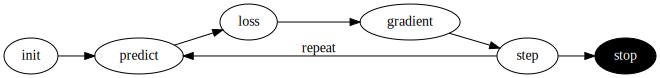

In [40]:
#id step function again
#caption The step function in our gradient descent process
#alt Graph showing the steps for Gradient Descent with step highlighted
gv('''
init->predict->loss->gradient->step->stop
stop[style=filled,fillcolor=black,fontcolor=white]
step->predict[label=repeat]
''')

## Let's test our Learner

There is only one thing left to do: have our learning rate ready and launch `fit` to see how well our Learner is doing!

In [32]:
lr = .1
learn.fit(40, lr=lr)

0.7794 0.85 0.8804 0.9044 0.9147 0.923 0.9304 0.9333 0.9343 0.9353 0.9367 0.9407 0.9436 0.9465 0.9475 0.9495 0.95 0.95 0.9509 0.9509 0.9514 0.9524 0.9524 0.9529 0.9539 0.9539 0.9539 0.9544 0.9544 0.9544 0.9554 0.9563 0.9568 0.9568 0.9568 0.9568 0.9578 0.9578 0.9578 0.9583 

That's a lot of numbers. As we have been taught in the book, we could instead plot the accuracy for our epochs.

Our dirty simple `recorder` will show its usefulness:

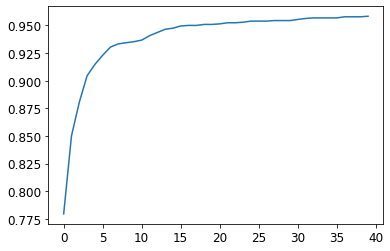

In [33]:
plt.plot(learn.recorder.keys(), learn.recorder.values())

## Wrap-up

Playing with the learning rate might yield better results, But the goal today was to have a working Learner and review a few parts of chapter 4, so I'll call it a success.

I'm pretty excited about reading on the learning rate finder.

Something I mostly (not to say completely!) glossed over is the reasoning behind using gradients for weight adjustment. If you are still unclear on this aspect, I recommend to reread the relevant parts in the book as they provide a fantastic intuition. Khan Academy is also replete with calculus lessons and exercises if you want to dive deeper in this subject.

The big picture here is that gradients are making parameter adjustments faster.

## What's next?

There is another, more exciting and potentially much more difficult task ahead: using the principles learned so far to work on the whole MNIST dataset.

I may use the built-in fastai features to do this work, but I expect things to be very instructive. Today's work was mostly seeing how the pieces fit together. This next project will be about providing useful work.